In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

가상의 강아지 보호소 데이터 구성.<br>
- start : 보호소 입소 시간
- end : 입양 사건 발생 시간. 9는 관측 종료 시점이므로 해당 컬럼이 9일 경우 cencored
- status : 1일 경우 사건 발생, 0일 경우 사건 미발생

In [2]:
obs = pd.DataFrame()

obs['start'] = 0,1,2,2,4,6,7
obs['end'] = 5,2,6,9,9,8,9
obs['status'] = 1,1,1,0,0,1,0
obs

,start,end,status
0,0,5,1
1,1,2,1
2,2,6,1
3,2,9,0
4,4,9,0
5,6,8,1
6,7,9,0


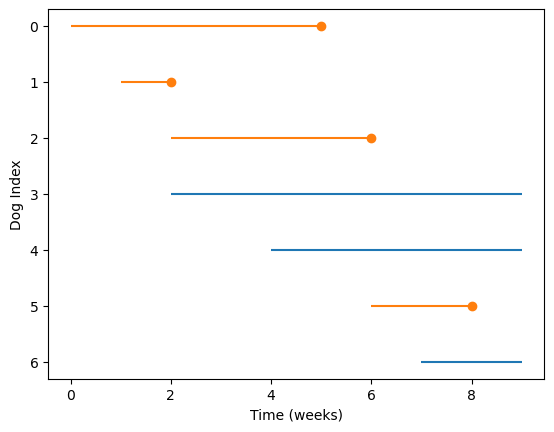

In [3]:
def plot_lifelines(obs):
    for y,row in obs.iterrows():
        start = row['start']
        end = row['end']
        status = row['status']

        if status == 0:
            plt.hlines(y,start,end,color='C0')
        else :
            plt.hlines(y,start,end,color='C1')
            plt.plot(end,y,marker='o',color='C1')
    plt.xlabel('Time (weeks)')
    plt.ylabel('Dog Index')
    plt.gca().invert_yaxis()

plot_lifelines(obs)

카플란 마이어 추정은 두가지 아이디어에서 시작한다.
1. 레코드의 시작지점을 무시하고 duration time만을 고려한다.

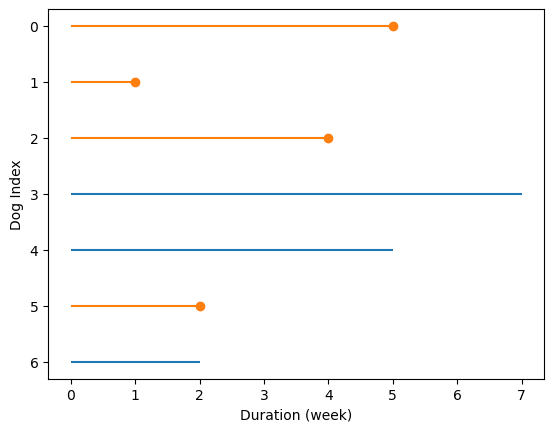

In [4]:
duration = obs['end'] - obs['start']
shifted = obs.copy()
shifted['start'] = 0
shifted['end'] = duration

plot_lifelines(shifted)
plt.xlabel('Duration (week)');

카플란 마이어 추정의 두번째 아이디어는 위험 함수를 추정하는 것이다. 위험함수는 아래를 고려한다.
1. 각 기간 내 발생한 사건을 위험에 처한 총 레코드 수로 나눈다.

In [5]:
ts = duration.unique()
ts.sort()
ts

array([1, 2, 4, 5, 7])

In [6]:
E,T = np.meshgrid(shifted['end'],ts)
E

array([[5, 1, 4, 7, 5, 2, 2],
       [5, 1, 4, 7, 5, 2, 2],
       [5, 1, 4, 7, 5, 2, 2],
       [5, 1, 4, 7, 5, 2, 2],
       [5, 1, 4, 7, 5, 2, 2]])

The above code is calculating the number of individuals at risk in a survival analysis study. 
The E array represents the observed event times and 
the T array represents the censoring times. 
The "at_risk" variable is calculated by counting the number of individuals 
in each time period who have not yet experienced an event or been censored. 
This is done by comparing the censoring times to the observed event times and 
summing the number of times the censoring time is less than or equal to the event time 
for each time period. 
The resulting "at_risk" array represents the number of individuals at risk in each time period.

First, we compare each element of T with the corresponding element of E:


T<br>
[<br>
    [1, 1, 1, 1, 1, 1, 1],<br>
    [2, 2, 2, 2, 2, 2, 2],<br>
    [4, 4, 4, 4, 4, 4, 4],<br>
    [5, 5, 5, 5, 5, 5, 5],<br>
    [7, 7, 7, 7, 7, 7, 7]<br>
]<br>

<=<br>
E<br>
[<br>
    [5, 1, 4, 7, 5, 2, 2],<br>
    [5, 1, 4, 7, 5, 2, 2],<br>
    [5, 1, 4, 7, 5, 2, 2],<br>
    [5, 1, 4, 7, 5, 2, 2],<br>
    [5, 1, 4, 7, 5, 2, 2]<br>
]<br>

This results in a boolean array:

[<br>
    [True,  True,  True,  True,  True,  True,  True],<br>
    [True, False,  True, True,  True, True, True],<br>
    [True, False,  True, True,  True, False, False],<br>
    [True, False,  False, True,  True, False, False],<br>
    [False, False, False, True, False, False, False]<br>
]<br>

We then sum each row of this boolean array, which counts the number of `True` values in each row:

[7, 6, 4, 3, 1]

This gives us the number of individuals who are considered "at risk" for each time point.


In [7]:
at_risk = (T <= E).sum(axis=1)
at_risk

array([7, 6, 4, 3, 1])

### 위험함수 추정
t = duration time. 각 t마다 입양이 발생한 수를 계산한다.

In [8]:
adopted = pd.Series(0,index=ts)

for t in ts:
    k = (shifted['status']==1) & (t == shifted['end'])
    adopted[t] = k.sum()

adopted

1    1
2    1
4    1
5    1
7    0
dtype: int64

In [9]:
d = dict(adopted=adopted,
        at_risk=at_risk)
df= pd.DataFrame(d,index=ts)
df

,adopted,at_risk
1,1,7
2,1,6
4,1,4
5,1,3
7,0,1


In [10]:
df['hazard'] = df['adopted']/df['at_risk']
df

,adopted,at_risk,hazard
1,1,7,0.142857
2,1,6,0.166667
4,1,4,0.250000
5,1,3,0.333333
7,0,1,0.000000


위에서 계산한 위험함수는 특정 기간에 사건이 발생할 확률이다. 이 케이스에서 사건은 입양이다.<br>
따라서 반대의 케이스는 입양이 되지 않은 생존이며, 이 생존의 누적곱이 생존함수가 된다.

In [11]:
df['surv'] = (1 - df['hazard']).cumprod()
df

,adopted,at_risk,hazard,surv
1,1,7,0.142857,0.857143
2,1,6,0.166667,0.714286
4,1,4,0.250000,0.535714
5,1,3,0.333333,0.357143
7,0,1,0.000000,0.357143


누적 분포함수는 1 - 생존함수이다.

In [12]:
df['cdf'] = 1 - df['surv']
df

,adopted,at_risk,hazard,surv,cdf
1,1,7,0.142857,0.857143,0.142857
2,1,6,0.166667,0.714286,0.285714
4,1,4,0.250000,0.535714,0.464286
5,1,3,0.333333,0.357143,0.642857
7,0,1,0.000000,0.357143,0.642857


확률 질량함수는 cdf의 변화량이다

In [13]:
df['pdf'] = np.diff(df['cdf'],prepend=0)
df

,adopted,at_risk,hazard,surv,cdf,pdf
1,1,7,0.142857,0.857143,0.142857,0.142857
2,1,6,0.166667,0.714286,0.285714,0.142857
4,1,4,0.250000,0.535714,0.464286,0.178571
5,1,3,0.333333,0.357143,0.642857,0.178571
7,0,1,0.000000,0.357143,0.642857,0.000000


### 라이브러리를 이용한 카플란마이어 생존곡선

In [16]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [19]:
T = shifted['end']
E = shifted['status']

In [21]:
kmf.fit(T,E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 7 total observations, 3 right-censored observations>

In [25]:
kmf.survival_function_


,KM_estimate
timeline,
0.0,1.000000
1.0,0.857143
2.0,0.714286
4.0,0.535714
5.0,0.357143
7.0,0.357143


생존함수의 confidence interval을 구할 수 있다. 현재 예제의 자료가 매우 작기에 CI는 상당히 넓다.

In [31]:
ci = kmf.confidence_interval_survival_function_
ci

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.0,1.000000,1.000000
1.0,0.334054,0.978561
2.0,0.258154,0.919797
4.0,0.131988,0.824997
5.0,0.051977,0.698713
7.0,0.051977,0.698713


Text(0, 0.5, 'Survival function')

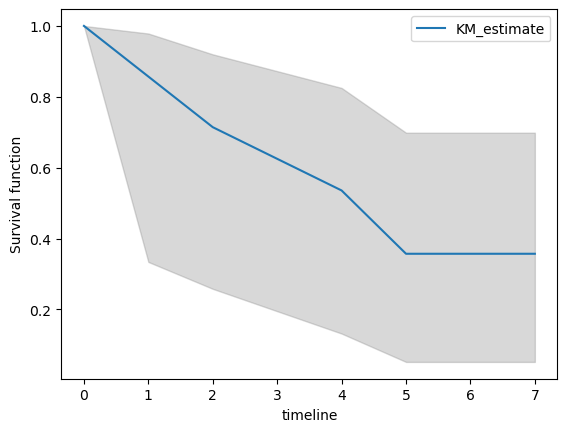

In [35]:
ts = ci.index
low, high = np.transpose(ci.values)
plt.fill_between(ts,low,high,color='grey',alpha=0.3)
kmf.survival_function_.plot(ax=plt.gca())
plt.ylabel('Survival function')

In [43]:
kmf.predict(5)

0.3571428571428571

<AxesSubplot:xlabel='timeline'>

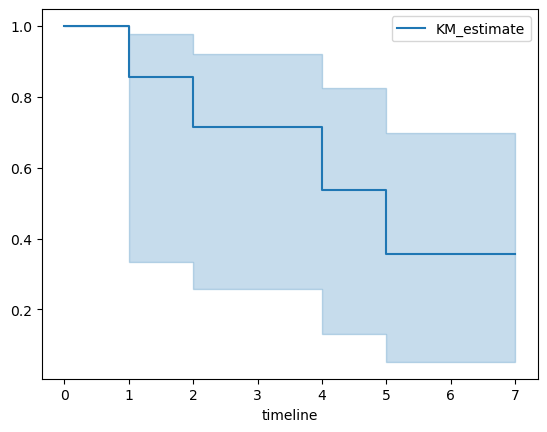

In [45]:
kmf.plot()

<AxesSubplot:xlabel='timeline'>

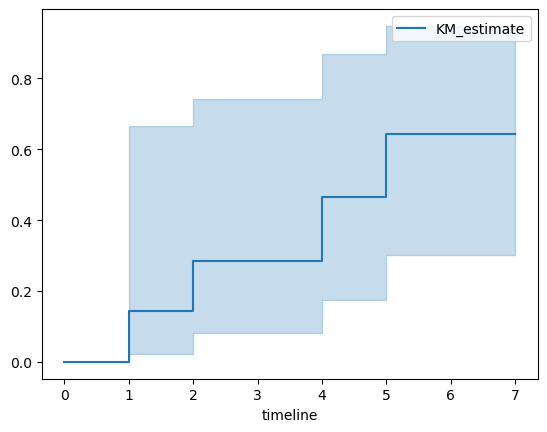

In [47]:
kmf.plot_cumulative_density()

In [48]:
kmf.median_survival_time_

5.0